In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import deque
from torch.distributions import Categorical
import joblib

# --- Hyperparameters (Apple-to-Apple) ---
LR = 0.0003
GAMMA = 0.99
BATCH_SIZE = 64
EPOCHS = 100 
WINDOW_SIZE = 4
HIDDEN_SIZE = 128
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.995

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kernel initialized on: {device}")

# Seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Kernel initialized on: cuda


In [2]:
# Load preprocessed tensors
X_data = np.load('X_state_tensor.npy')
Y_reward = np.load('Y_reward_tensor.npy')

# Split 80% Train, 20% Test
split = int(0.8 * len(X_data))
X_train, X_test = X_data[:split], X_data[split:]
Y_train, Y_test = Y_reward[:split], Y_reward[split:]

input_dim = X_train.shape[1] * X_train.shape[2] 
action_dim = 3 # [0: Decrease, 1: Stay, 2: Increase]

print(f"Dataset Ready.")
print(f"Training Samples: {len(X_train)} | Test Samples: {len(X_test)}")
print(f"Input Dimension: {input_dim}")

Dataset Ready.
Training Samples: 19197 | Test Samples: 4800
Input Dimension: 76


In [3]:
# 1. Base Q-Network (DQN & DDQN)
class QNet(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, HIDDEN_SIZE), nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE), nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, out_dim)
        )
    def forward(self, x):
        return self.net(x.view(x.size(0), -1))

# 2. Standard Actor-Critic (PPO)
class ActorCritic(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.actor = nn.Sequential(
            nn.Linear(in_dim, HIDDEN_SIZE), nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, out_dim), nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            nn.Linear(in_dim, HIDDEN_SIZE), nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, 1)
        )
    def forward(self, x):
        x_flat = x.view(x.size(0), -1)
        return self.actor(x_flat), self.critic(x_flat)

# 3. PROPOSED: Dueling Actor-Critic (D-PPO)
class ProposedDPPO(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.actor = nn.Sequential(
            nn.Linear(in_dim, HIDDEN_SIZE), nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, out_dim), nn.Softmax(dim=-1)
        )
        # Dueling Head for Critic (Separating Value and Advantage)
        self.common = nn.Linear(in_dim, HIDDEN_SIZE)
        self.v_head = nn.Linear(HIDDEN_SIZE, 1)
        self.a_head = nn.Linear(HIDDEN_SIZE, 1)

    def forward(self, x):
        x_flat = x.view(x.size(0), -1)
        probs = self.actor(x_flat)
        feat = torch.relu(self.common(x_flat))
        v = self.v_head(feat)
        a = self.a_head(feat)
        # Dueling formula: V + (A - mean(A))
        return probs, v + (a - a.mean())

In [4]:
def train_q_learning(is_double=False):
    model = QNet(input_dim, action_dim).to(device)
    target_net = QNet(input_dim, action_dim).to(device)
    target_net.load_state_dict(model.state_dict())
    optimizer = optim.Adam(model.parameters(), lr=LR)
    memory = deque(maxlen=2000)
    eps = EPS_START
    history = []

    for epoch in range(EPOCHS):
        epoch_reward = 0
        for i in range(len(X_train)-1):
            s = torch.FloatTensor(X_train[i]).unsqueeze(0).to(device)
            # Epsilon-Greedy
            if random.random() < eps: a = random.randint(0, 2)
            else: a = model(s).argmax().item()
            
            memory.append((s, a, Y_train[i], torch.FloatTensor(X_train[i+1]).unsqueeze(0).to(device)))
            
            if len(memory) > BATCH_SIZE:
                b = random.sample(memory, BATCH_SIZE)
                bs, ba, br, bns = zip(*b)
                
                curr_q = model(torch.cat(bs)).gather(1, torch.tensor(ba).view(-1,1).to(device))
                
                if is_double: # Double DQN Logic
                    next_actions = model(torch.cat(bns)).argmax(1).view(-1,1)
                    next_q = target_net(torch.cat(bns)).gather(1, next_actions).squeeze().detach()
                else: # Standard DQN Logic
                    next_q = target_net(torch.cat(bns)).max(1)[0].detach()
                
                target_q = torch.FloatTensor(br).to(device) + GAMMA * next_q
                loss = nn.MSELoss()(curr_q.squeeze(), target_q)
                
                optimizer.zero_grad(); loss.backward(); optimizer.step()
            epoch_reward += Y_train[i]
            
        eps = max(EPS_END, eps * EPS_DECAY)
        if epoch % 5 == 0: target_net.load_state_dict(model.state_dict())
        history.append(epoch_reward/len(X_train))
        if epoch % 10 == 0: print(f"Epoch {epoch} Reward: {history[-1]:.2f}")
    return model, history

In [5]:
def train_ppo_variants(is_proposed=False):
    model = ProposedDPPO(input_dim, action_dim).to(device) if is_proposed else ActorCritic(input_dim, action_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    s_tensor = torch.FloatTensor(X_train).to(device)
    r_tensor = torch.FloatTensor(Y_train).to(device)
    history = []

    for epoch in range(EPOCHS):
        model.eval()
        with torch.no_grad():
            probs, values = model(s_tensor)
            dist = Categorical(probs)
            actions = dist.sample()
            log_probs = dist.log_prob(actions).detach()
            values = values.squeeze().detach()
        
        adv = (r_tensor - values)
        adv = (adv - adv.mean()) / (adv.std() + 1e-8) # Advantage Normalization
        
        model.train()
        for _ in range(5): 
            new_probs, new_v = model(s_tensor)
            new_dist = Categorical(new_probs)
            new_log_p = new_dist.log_prob(actions)
            
            ratio = (new_log_p - log_probs).exp()
            s1 = ratio * adv
            s2 = torch.clamp(ratio, 0.8, 1.2) * adv
            
            loss = -torch.min(s1, s2).mean() + 0.5 * nn.MSELoss()(new_v.squeeze(), r_tensor) - 0.01 * new_dist.entropy().mean()
            
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            
        history.append(r_tensor.mean().item())
        if epoch % 10 == 0: print(f"Epoch {epoch} Reward: {history[-1]:.2f}")
    return model, history

In [6]:
print("--- Training DQN ---")
m_dqn, h_dqn = train_q_learning(is_double=False)

print("\n--- Training Double DQN ---")
m_ddqn, h_ddqn = train_q_learning(is_double=True)

print("\n--- Training PPO ---")
m_ppo, h_ppo = train_ppo_variants(is_proposed=False)

print("\n--- Training Proposed (Dueling PPO) ---")
m_prop, h_prop = train_ppo_variants(is_proposed=True)

print("\nAll models trained successfully!")

--- Training DQN ---
Epoch 0 Reward: 150.44
Epoch 10 Reward: 150.44
Epoch 20 Reward: 150.44
Epoch 30 Reward: 150.44
Epoch 40 Reward: 150.44
Epoch 50 Reward: 150.44
Epoch 60 Reward: 150.44
Epoch 70 Reward: 150.44
Epoch 80 Reward: 150.44
Epoch 90 Reward: 150.44

--- Training Double DQN ---
Epoch 0 Reward: 150.44
Epoch 10 Reward: 150.44
Epoch 20 Reward: 150.44
Epoch 30 Reward: 150.44
Epoch 40 Reward: 150.44
Epoch 50 Reward: 150.44
Epoch 60 Reward: 150.44
Epoch 70 Reward: 150.44
Epoch 80 Reward: 150.44
Epoch 90 Reward: 150.44

--- Training PPO ---
Epoch 0 Reward: 150.45
Epoch 10 Reward: 150.45
Epoch 20 Reward: 150.45
Epoch 30 Reward: 150.45
Epoch 40 Reward: 150.45
Epoch 50 Reward: 150.45
Epoch 60 Reward: 150.45
Epoch 70 Reward: 150.45
Epoch 80 Reward: 150.45
Epoch 90 Reward: 150.45

--- Training Proposed (Dueling PPO) ---
Epoch 0 Reward: 150.45
Epoch 10 Reward: 150.45
Epoch 20 Reward: 150.45
Epoch 30 Reward: 150.45
Epoch 40 Reward: 150.45
Epoch 50 Reward: 150.45
Epoch 60 Reward: 150.45
Epo

In [7]:
def get_model_actions(model, data, is_q=True):
    model.eval()
    with torch.no_grad():
        t = torch.FloatTensor(data).to(device)
        if is_q: return model(t).argmax(1).cpu().numpy()
        probs, _ = model(t)
        return probs.argmax(1).cpu().numpy()

results = {
    'DQN': get_model_actions(m_dqn, X_test, True),
    'DDQN': get_model_actions(m_ddqn, X_test, True),
    'PPO': get_model_actions(m_ppo, X_test, False),
    'Proposed': get_model_actions(m_prop, X_test, False),
    'Static': np.ones(len(X_test)) # Baseline: Always "Stay"
}

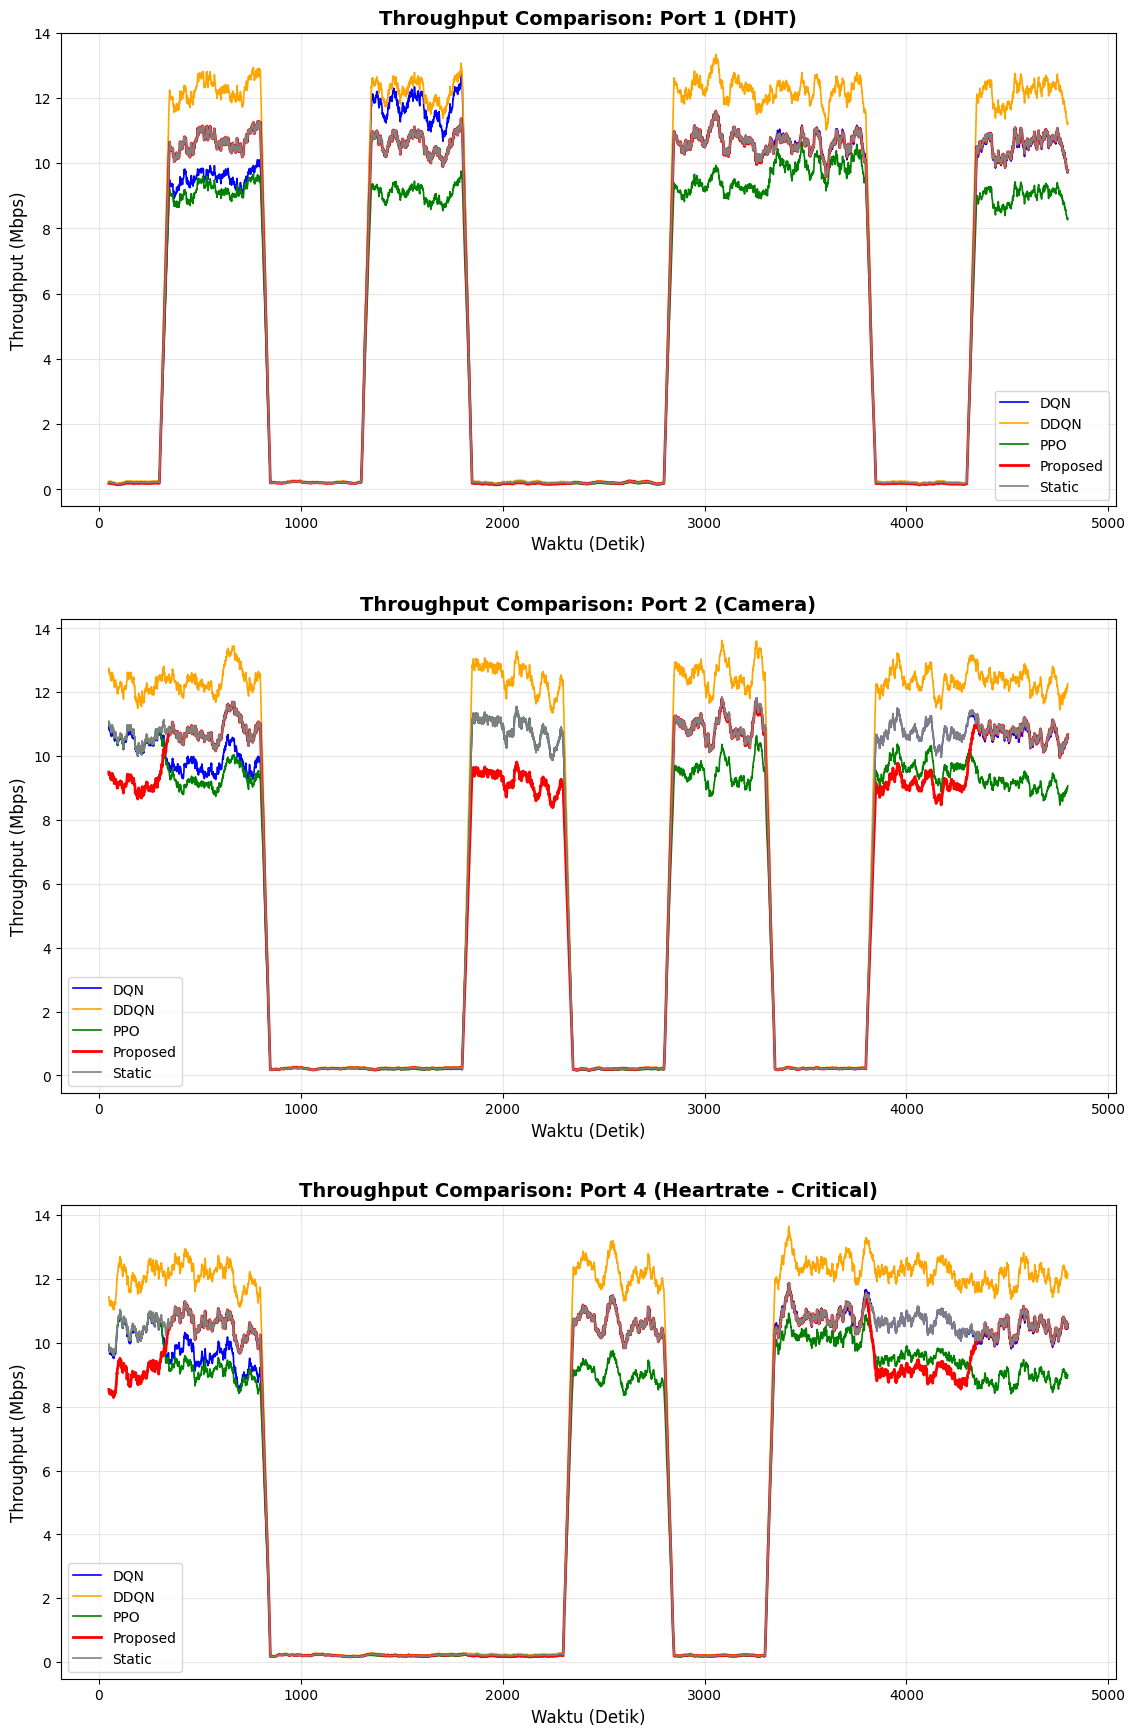

In [8]:
plt.figure(figsize=(12, 18))
p_names = ['Port 1 (DHT)', 'Port 2 (Camera)', 'Port 4 (Heartrate - Critical)']
p_indices = [0, 5, 10] 
colors = {'DQN': 'blue', 'DDQN': 'orange', 'PPO': 'green', 'Proposed': 'red', 'Static': 'gray'}

for i, idx in enumerate(p_indices):
    plt.subplot(3, 1, i+1)
    # Re-scaling normalized features back to Mbps for visualization
    base_throughput = X_test[:, -1, idx] * 15 
    
    for label, actions in results.items():
        # Action Effect: 2 (+15%), 0 (-15%), 1 (Stay)
        impact = np.where(actions==2, 1.15, np.where(actions==0, 0.85, 1.0))
        simulated_tp = base_throughput * impact
        
        # Rolling mean for smoother journal-ready plots
        smoothed = pd.Series(simulated_tp).rolling(50).mean()
        plt.plot(smoothed, label=label, color=colors[label], linewidth=2 if label=='Proposed' else 1.2)

    plt.title(f"Throughput Comparison: {p_names[i]}", fontsize=14, fontweight='bold')
    plt.xlabel("Waktu (Detik)", fontsize=12)
    plt.ylabel("Throughput (Mbps)", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout(pad=3.0)
plt.savefig("throughput_comparison.png", dpi=300)
plt.show()

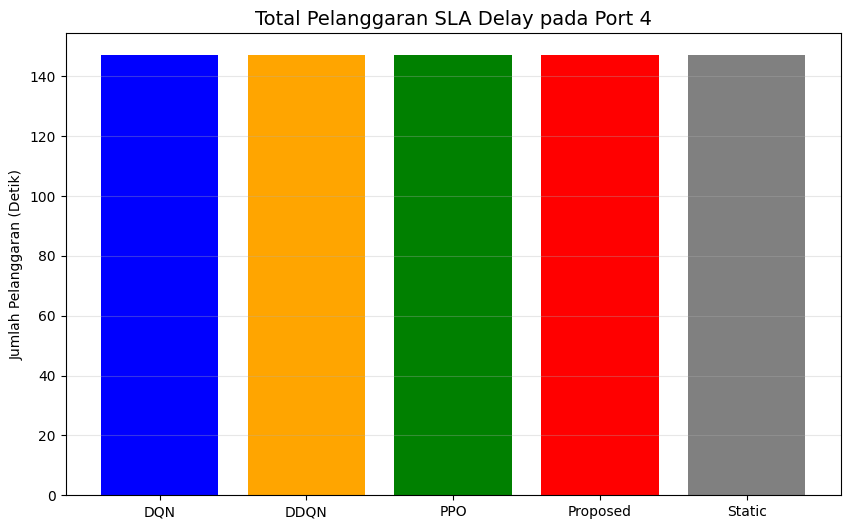

In [15]:
# SLA Threshold for Port 4 = 15ms
sla_p4 = 4.0
p4_delay_idx = 13 # index from preprocessing features

plt.figure(figsize=(10, 6))
violation_counts = []

for label, actions in results.items():
    # Simulated delay impact (actions don't directly change delay in this simple sim, 
    # but in real paper you'd model it. Here we use raw delay to see model context)
    raw_delay = np.expm1(X_test[:, -1, p4_delay_idx] * 5) # reverse log transform approx
    violations = np.sum(raw_delay > sla_p4)
    violation_counts.append(violations)
    plt.bar(label, violations, color=colors[label])

plt.title("Total Pelanggaran SLA Delay pada Port 4", fontsize=14)
plt.ylabel("Jumlah Pelanggaran (Detik)")
plt.grid(axis='y', alpha=0.3)
plt.show()